In [109]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import ipywidgets as iw
import dronesim
from pid import PID
import good_controller as cont
import pandas as pd
from scipy.signal import find_peaks

In [110]:
def simulate(cd, target_x, target_y): # simulate a ControlledDrone instance...
    dt = 0.03 # timestep
    ts = np.arange(0,30,dt)
    xs,ys,thetas,lts,rts = [],[],[],[],[] # save here the x,y,theta coordinates of the drone
    for t in ts:
        cd.step(dt, target_x, target_y)
        x,y = cd.drone.getxy()
        xs.append(x)
        ys.append(y)
        lts.append(cd.drone.lt)
        rts.append(cd.drone.rt)
        thetas.append(cd.drone.gettheta())
    fig,axs = plt.subplots(nrows=4, sharex=True, figsize=(8,12))
    axs[0].plot(ts,xs)
    axs[0].axhline(target_x, color='red')
    axs[0].set(ylabel="x position [m]")
    axs[1].plot(ts,ys)
    axs[1].axhline(target_y, color='red')
    axs[1].set(ylabel="height [m]")
    axs[2].plot(ts,np.rad2deg(thetas))
    axs[2].set(ylabel="theta [deg]")
    axs[3].plot(ts,lts)
    axs[3].plot(ts,rts)
    axs[3].set(ylabel="thrust [N]", xlabel = "time [s]")

    return ts, xs, ys, lts, rts, thetas

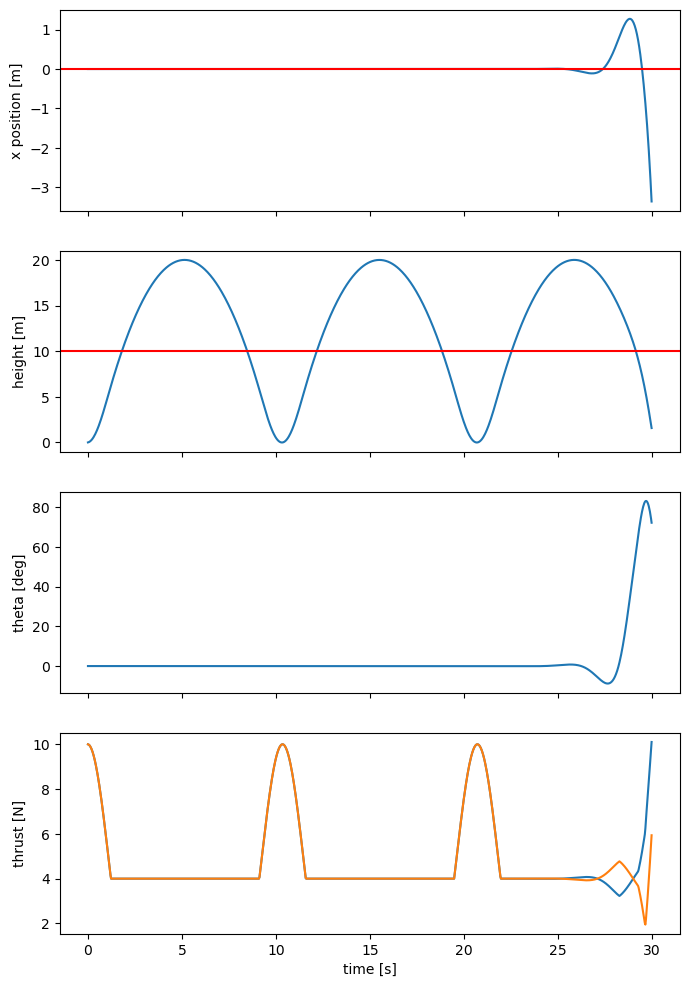

In [111]:
#BEFORE OPTIMISING Y
importlib.reload(cont) # make sure we have the latest version if it was edited
initial_pose = dronesim.mktr(0,0) @ dronesim.mkrot(0)
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
c.y_pid = PID(1,0,0)
c.x_pid = PID(1,0,0)
c.theta_pid = PID(1,0,0)
cd = dronesim.ControlledDrone(drone=d, controller=c)
ts, xs, ys, lts, rts, thetas = simulate(cd, target_x=0, target_y=10)

In [112]:
peaks, properties = find_peaks(ys)

In [113]:
peaks

array([171, 517, 862])

In [114]:
peak_times = []
for i, peak in enumerate(peaks):
    peak_times.append(ts[peak])
peak_times

[5.13, 15.51, 25.86]

In [115]:
T_u = np.average(np.diff(peak_times))
K_u = 1
print(f'Oscillation Period T_u: {T_u}')
print(f'Ultimate Gain K_u: {K_u}')

Oscillation Period T_u: 10.364999999999998
Ultimate Gain K_u: 1


In [116]:
#Classic PID
P = 0.6*K_u
I = 1.2*K_u/T_u
D = 0.075*K_u*T_u
print(P, I, D)

#no overshoot PID
# P = 0.2*K_u
# I = 0.4*K_u/T_u
# D = 1/15*K_u*T_u
# print(P, I, D)



0.6 0.11577424023154849 0.7773749999999998


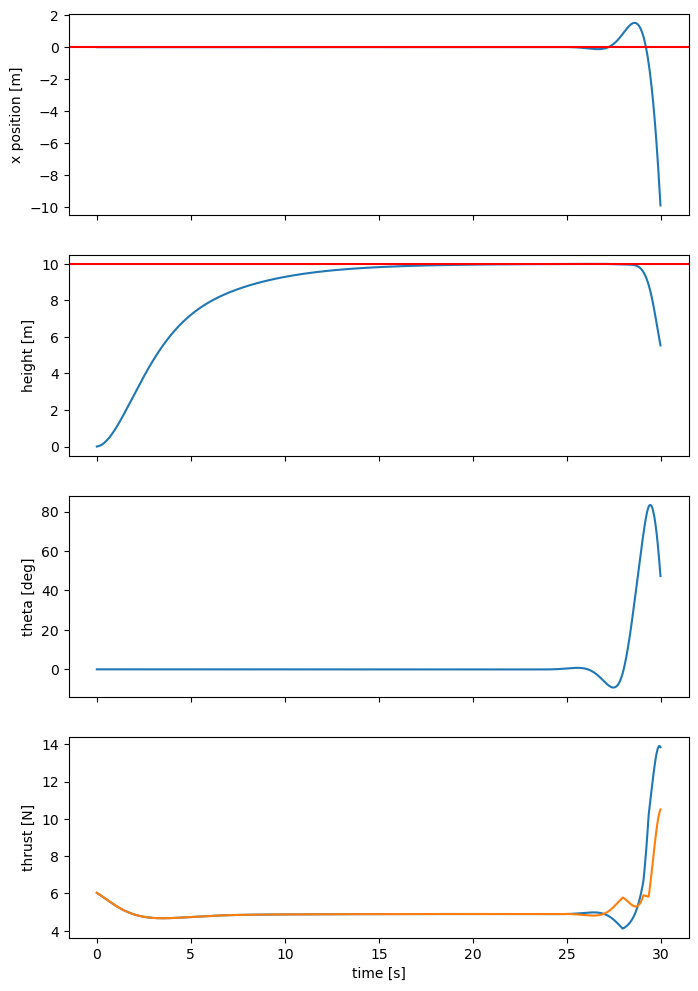

In [117]:
# AFTER OPTIMISING Y
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
c.y_pid = PID(P,I,D)
cd = dronesim.ControlledDrone(drone=d, controller=c)
ts, xs, ys, lts, rts, thetas = simulate(cd, target_x=0, target_y=10)

## Controller becomes unstable only because x_pid and theta_pid are not tuned yet

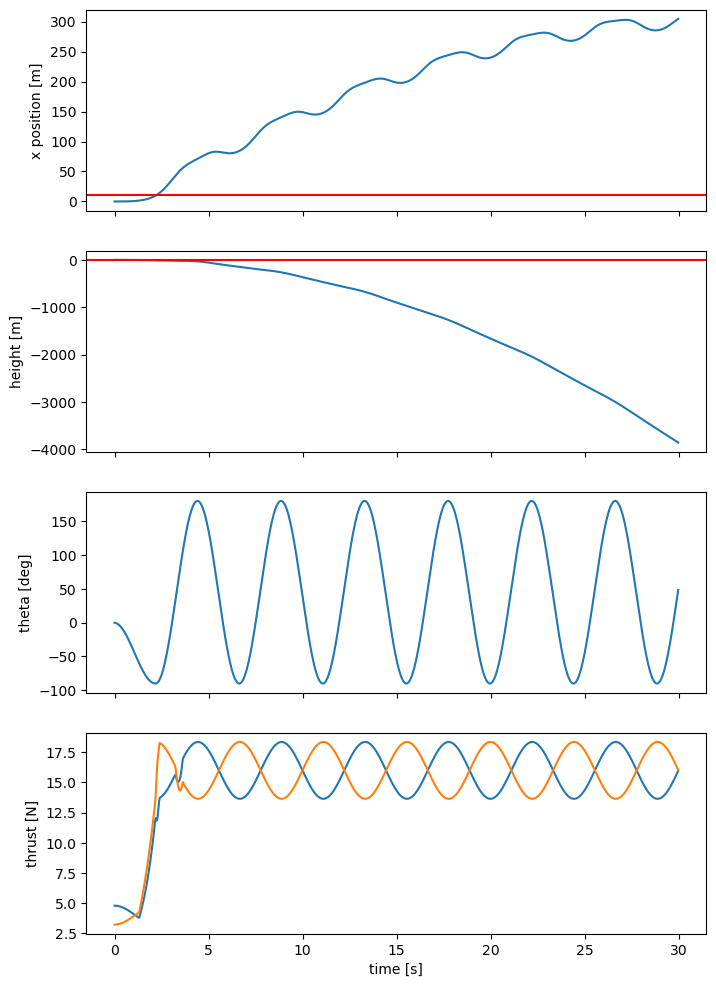

In [118]:
## BEFORE OPTIMISING THETA
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
c.y_pid = PID(P,I,D)
c.x_pid = PID(1,0,0)
c.theta_pid = PID(1,0,0)
cd = dronesim.ControlledDrone(drone=d, controller=c)
ts, xs, ys, lts, rts, thetas = simulate(cd, target_x=10, target_y=0)

Oscillation Period T_u: 4.4399999999999995
Ultimate Gain K_u: 1
0.6 0.2702702702702703 0.33299999999999996


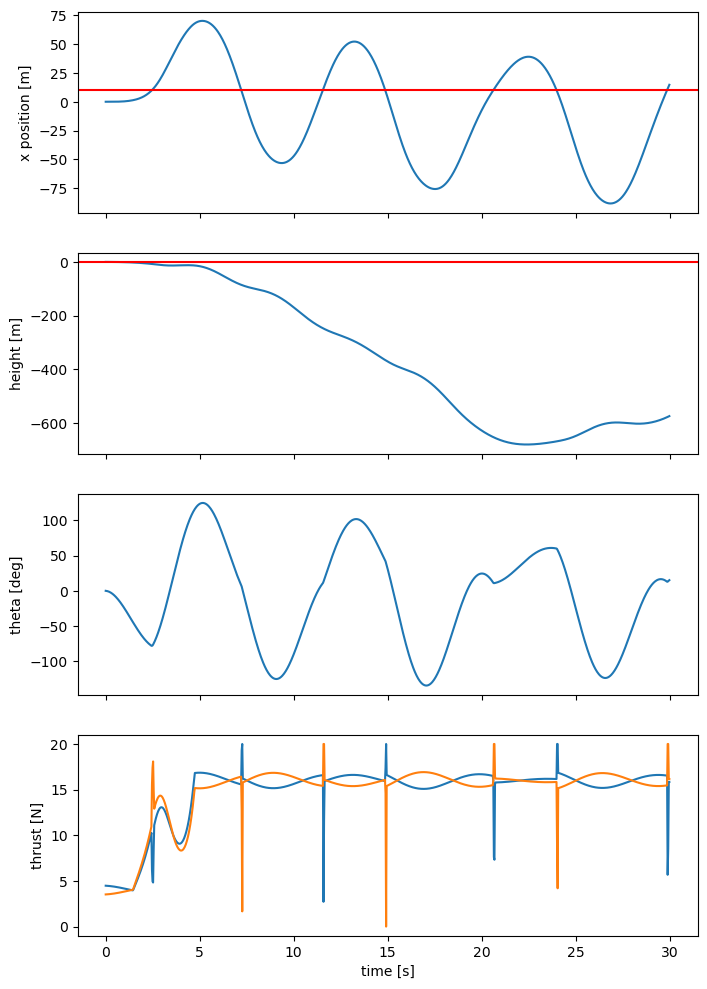

In [119]:
peaks, properties = find_peaks(thetas)
peak_times = []
for i, peak in enumerate(peaks):
    peak_times.append(ts[peak])
peak_times

# if len(peak_times) > 2:
#     T_u = np.average(np.diff(peak_times))
# else:
#     T_u = np.diff(peak_times)

T_u = np.average(np.diff(peak_times))
K_u = 1
print(f'Oscillation Period T_u: {T_u}')
print(f'Ultimate Gain K_u: {K_u}')

#Classic PID
P = 0.6*K_u
I = 1.2*K_u/T_u
D = 0.075*K_u*T_u
print(P, I, D)

#no overshoot PID
# P = 0.2*K_u
# I = 0.4*K_u/T_u
# D = 1/15*K_u*T_u
# print(P, I, D)

# AFTER OPTIMISING THETA
d = dronesim.Drone2D(initial_pose=initial_pose, mass=1, L=1, maxthrust=20)
c = cont.Controller(maxthrust=d.maxthrust)
c.theta_pid = PID(P,I,D)
cd = dronesim.ControlledDrone(drone=d, controller=c)
ts, xs, ys, lts, rts, thetas = simulate(cd, target_x=10, target_y=0)

## Controller becomes unstable only because x_pid and theta_pid are not tuned yet